In [127]:
import matplotlib.pyplot as plt
import numpy as np

import transformers
from transformers import CLIPTokenizer, CLIPTextModel, CLIPProcessor, CLIPModel

transformers.logging.set_verbosity_error()
plt.rcParams['figure.dpi'] = 300

In [2]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
    cache_dir="data/models/openai/clip-vit-large-patch14",
    local_files_only=True,
)
text_model = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14", 
    cache_dir="data/models/openai/clip-vit-large-patch14",
    local_files_only=True,
)

In [3]:
def embed(text):
    input_ids = tokenizer(text, return_tensors="pt").input_ids
    tensor = text_model(input_ids).pooler_output
    return tensor.squeeze().detach().numpy()

In [115]:
objects = ["cat", "dog", "horse", "cow", "giraffe", "zebra", "lion", "tiger", "bear", "monkey", "sheep", "pig", "mouse", "rat", "rabbit"] 
modifiers = {
    "low": "low resolution",
    "default": "",
    "high": "high resolution",
    "ultra": "ultra high resolution",
}
mod_colors = {
    "low": "tab:red",
    "default": "tab:blue",
    "high": "tab:orange",
    "ultra": "tab:green",
}

In [116]:
embeddings = {}
for mod_name, mod in modifiers.items():
    embeddings[mod_name] = {}
    for obj in objects:
        emb = embed(f"a {mod} photo of a {obj}")
        embeddings[mod_name][obj] = emb

In [147]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

v = np.vstack([embeddings[mod][obj] for mod in modifiers for obj in objects])

# tsne = TSNE(n_components=2, init="pca", perplexity=30, learning_rate='auto')
# result = tsne.fit_transform(v)

pca = PCA(n_components=2)
result = pca.fit_transform(v)

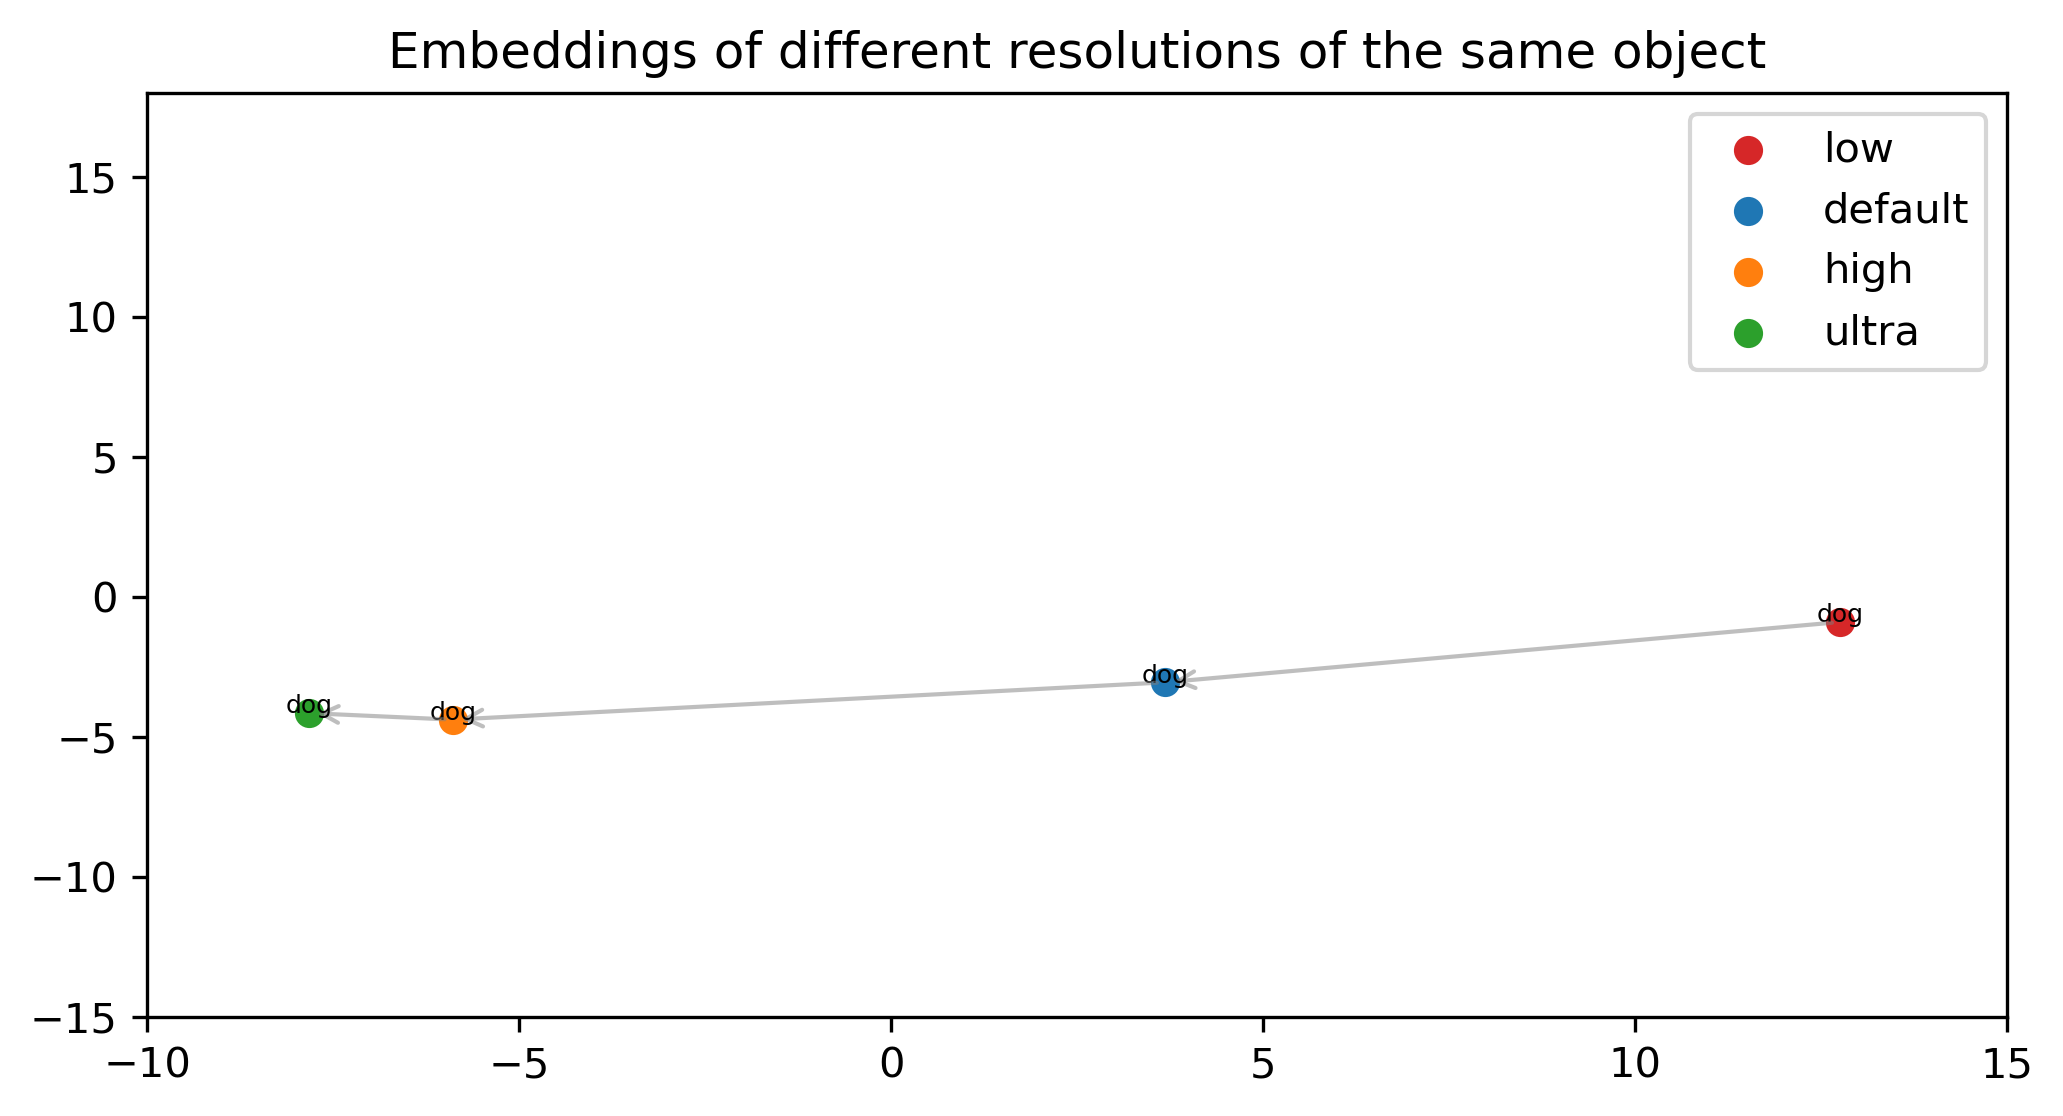

In [150]:
plt.figure(figsize=(8, 4))

for i, obj in enumerate(objects):
    if obj != "dog": continue
    for j, (mod_name, _) in enumerate(modifiers.items()):
        src = result[i + j*len(objects)]
        plt.annotate(obj, src, fontsize=6, xycoords='data', ha='center')
        plt.scatter(src[0], src[1], color=mod_colors[mod_name], label=mod_name)
        
        if j != len(modifiers) - 1:
            dst = result[i + (j+1)*len(objects)]
            plt.annotate("",
                xy=dst, 
                xytext=src,
                arrowprops=dict(arrowstyle="->", color="tab:gray", alpha=0.5),
            )

plt.xlim(-10, 15)
plt.ylim(-15, 18)
plt.title("Embeddings of different resolutions of the same object")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()